In [418]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [ ]:
path_parquet = 'data/parquet/'
path_csv = 'data/csv'

for file in os.listdir(path_parquet):
    if file.endswith('parquet'):
        df = pd.read_parquet(f'{path_parquet}/{file}')
        file_name = file.replace('parquet', 'csv')
        df.to_csv(f'{path_csv}/{file_name}', index=False)
        

In [3]:
df = []

for file in os.listdir(path_csv):
    if file.endswith('csv'):
        df.append(pd.read_csv(f'{path_csv}/{file}'))
        
df_events = df[0]
df_stories = df[1]
df_tracks = df[2]
df_runs = df[3]

In [237]:
# Stories är events 
# events är spelarnas position på planen i varje bildram 
# med df_runs kan man ta reda på total distans, medelhastighet, topphastighet

inter_team_id = 3161
inter_team_name = 'Inter'
inter_away_team = 'away_team'

mask = (df_tracks['team_name']==inter_team_name) & (df_tracks['player'])

player_names_inter = df_tracks[mask]
player_names_inter = player_names_inter[['player', 'jersey_number']]
player_names_inter = player_names_inter.drop_duplicates(subset='player', keep='first')

player_names_inter


,player,jersey_number
10,Denzel Dumfries,2
11,Lautaro Martínez,10
12,Hakan Çalhanoğlu,20
13,Nicolò Barella,23
14,André Onana,24
15,Federico Dimarco,32
16,Matteo Darmian,36
17,Marcelo Brozović,77
18,Alessandro Bastoni,95
28,Francesco Acerbi,15


In [561]:
mask_run = (df_runs['team']==inter_away_team) 

inters_runs = df_runs[mask_run]
"Runs: player_id, jersey, max_speed, avg_speed, player, approx_time_start, approx_time_end, time_start, time_end, Distance"
inters_runs = inters_runs[['player_id', 'jersey', 'time_start', 'time_end', 'approx_time_start', 'approx_time_end', 'max_speed', 'avg_speed', 'Distance', 'period']].reset_index()
inters_runs = inters_runs.drop(columns='index')
inters_runs

player_mapping = dict(zip(player_names_inter["jersey_number"], player_names_inter["player"]))

inters_runs["player_id"] = inters_runs["jersey"].map(player_mapping).fillna(inters_runs["jersey"])


end_game_intensity_decrement = inters_runs.copy()
temporary_intensity_decrement = inters_runs.copy()



In [672]:
end_game_intensity_decrement_copy = end_game_intensity_decrement.copy()
end_game_intensity_decrement_copy["time_start"] = end_game_intensity_decrement_copy["time_start"].astype(str)
end_game_intensity_decrement_copy["minutes"] = end_game_intensity_decrement_copy["time_start"].apply(lambda x: float(x.split(":")[0]) + (float(x.split(":")[1]) / 60))

end_game_intensity_decrement_copy['match_minute'] = np.floor(end_game_intensity_decrement_copy['minutes'] / 15) * 15

end_game_intensity_decrement_copy.loc[end_game_intensity_decrement_copy['period']==2, 'match_minute'] += 45
end_game_intensity_decrement_copy.loc[end_game_intensity_decrement_copy['match_minute'] > 90, 'match_minute'] = 90

end_game_intensity_decrement_copy["match_interval"] = end_game_intensity_decrement_copy["match_minute"].astype(int).astype(str) + "-" + \
                                np.minimum(end_game_intensity_decrement_copy["match_minute"] + 15, 96).astype(int).astype(str)

end_game_intensity_decrement_copy = end_game_intensity_decrement_copy.groupby('match_interval', as_index=False)['Distance'].sum()
end_game_intensity_decrement_copy = end_game_intensity_decrement_copy.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  


x_end_game = [end_game_intensity_decrement_copy['match_interval']]
y_end_game = [end_game_intensity_decrement_copy['Distance']]

In [650]:
temporary_intensity_decrement_copy = temporary_intensity_decrement.copy()

temporary_intensity_decrement_copy["time_start"] = temporary_intensity_decrement_copy["time_start"].astype(str)
temporary_intensity_decrement_copy["minutes"] = temporary_intensity_decrement_copy["time_start"].apply(lambda x: float(x.split(":")[0]) + (float(x.split(":")[1]) / 60))

temporary_intensity_decrement_copy['match_minute'] = np.floor(temporary_intensity_decrement_copy['minutes'] / 5) * 5
temporary_intensity_decrement_copy.loc[temporary_intensity_decrement_copy['period']==2, 'match_minute'] += 45
temporary_intensity_decrement_copy.loc[temporary_intensity_decrement_copy['match_minute'] > 90, 'match_minute'] = 90


temporary_intensity_decrement_copy["match_interval"] = temporary_intensity_decrement_copy["match_minute"].astype(int).astype(str) + "-" + \
                                np.minimum(temporary_intensity_decrement_copy["match_minute"] + 5, 96).astype(int).astype(str)

temporary_intensity_decrement_copy = temporary_intensity_decrement_copy[temporary_intensity_decrement_copy['max_speed']>24.0]
temporary_intensity_decrement_copy = temporary_intensity_decrement_copy.groupby('match_interval', as_index=False)['Distance'].sum()
temporary_intensity_decrement_copy = temporary_intensity_decrement_copy.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt

peak_index = temporary_intensity_decrement_copy['Distance'].idxmax()
peak_interval = temporary_intensity_decrement_copy.loc[peak_index, 'match_interval']
peak_distance = temporary_intensity_decrement_copy.loc[peak_index, 'Distance']
next_interval = temporary_intensity_decrement_copy.loc[peak_index + 1, 'match_interval'] 
next_distance = temporary_intensity_decrement_copy.loc[peak_index + 1, 'Distance']
mean_distance = temporary_intensity_decrement_copy['Distance'].mean()

x_temp = ['Max (25-30)', '5 min efter max (30-35)     ', 'Medelvärde (0-96)']          
y_temp = [peak_distance, next_distance, mean_distance]




In [792]:
first_half = inters_runs[inters_runs['period']==1]['Distance']
second_half = inters_runs[inters_runs['period']==2]['Distance']

t_test, p_value = ttest_ind(first_half, second_half, equal_var=False)

print(p_value)

0.14748615114221497


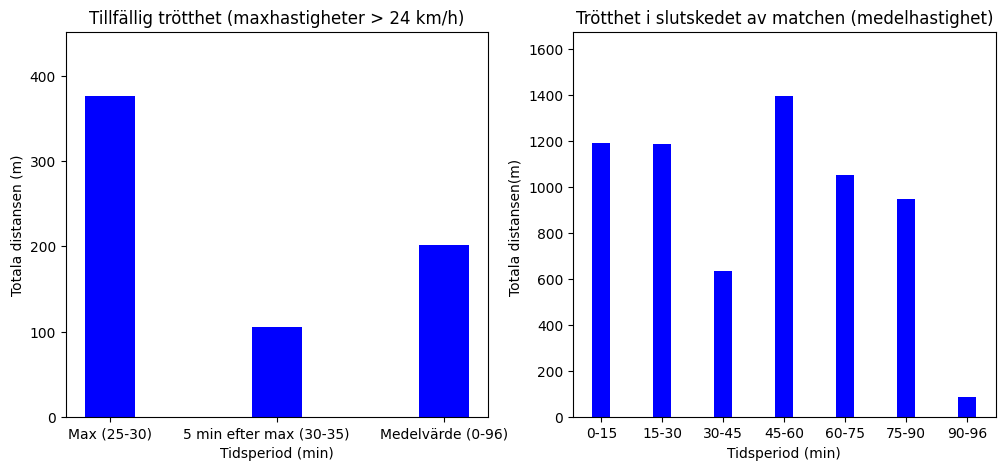

In [923]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)


axes[0].bar(x_temp, y_temp, color='blue', width=0.3)
axes[0].set_xlabel('Tidsperiod (min)')
axes[0].set_ylabel('Totala distansen (m)')
axes[0].set_ylim(0, max(y_temp) * 1.2)
axes[0].set_title('Tillfällig trötthet (maxhastigheter > 24 km/h)')

axes[1].bar(x_end_game, y_end_game[0], color='blue', width = 0.3)
axes[1].set_xlabel('Tidsperiod (min)')
axes[1].set_ylabel('Totala distansen(m) ')
axes[1].set_ylim(0, max(y_end_game[0]) * 1.2)
axes[1].set_title('Trötthet i slutskedet av matchen (medelhastighet)')

plt.show()


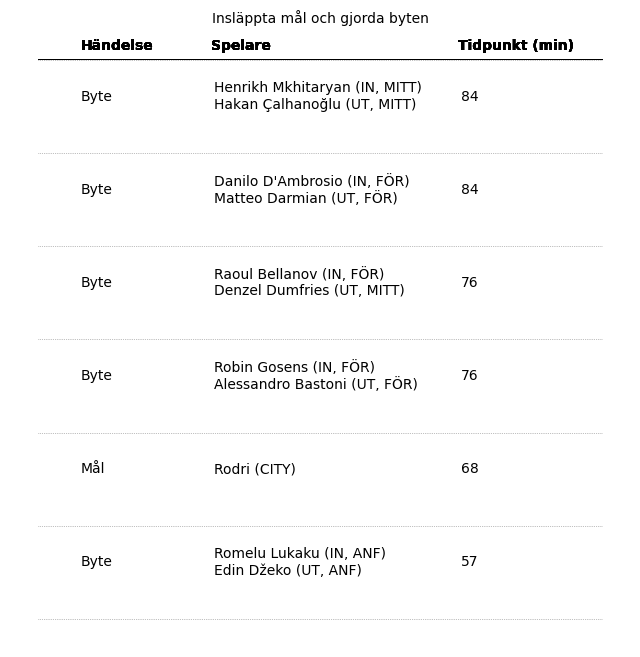

In [922]:
d = [{
        'Händelse': 'Byte',
        'Spelare': 'Romelu Lukaku (IN, ANF)\nEdin Džeko (UT, ANF)',
        'Tidpunkt (min)': 57
        },
        {
        'Händelse': 'Mål',
        'Spelare': 'Rodri (CITY)',
        'Tidpunkt (min)': 68
        },
        {
        'Händelse': 'Byte',
        'Spelare': "Robin Gosens (IN, FÖR)\nAlessandro Bastoni (UT, FÖR)",
        'Tidpunkt (min)': 76
        }, 
        {'Händelse': 'Byte',
         'Spelare': 'Raoul Bellanov (IN, FÖR)\nDenzel Dumfries (UT, MITT)',
         'Tidpunkt (min)': 76
         },
        {'Händelse': 'Byte', 
         'Spelare': "Danilo D'Ambrosio (IN, FÖR)\nMatteo Darmian (UT, FÖR)", 
         'Tidpunkt (min)': 84},
        
        {'Händelse': 'Byte', 
         'Spelare': 'Henrikh Mkhitaryan (IN, MITT)\nHakan Çalhanoğlu (UT, MITT)', 
         'Tidpunkt (min)': 84
                  
}]

fig, axes = plt.subplots(figsize=(8, 8))

rows = 7
cols = 3

axes.set_ylim(0, rows + 1)
axes.set_xlim(0, cols + 1)

for row in range(rows-1):
        data = d[row]
        #print(data['Händelse'])
        axes.text(x=.3, y=row, s=data['Händelse'], va='center', ha='left')
        axes.text(x=1.25, y=row, s=data['Spelare'], va='center', ha='left')
        axes.text(x=3, y=row, s=data['Tidpunkt (min)'], va='center', ha='left')
        axes.text(x=0.3, y=5.5, s='Händelse', weight='bold', ha='left')
        axes.text(x=1.65, y=5.5, s='Spelare', weight='bold', ha='right')
        axes.text(x=3.8, y=5.5, s='Tidpunkt (min)', weight='bold', ha='right')
        
for row in range(rows):
    axes.plot(
    	[0, cols + 1],
    	[row -.61, row - .61],
    	ls=':',
    	lw='.5',
    	c='grey'
    )
    axes.plot([0, cols+1], [5.4, 5.4], lw='.5', c='black')

axes.set_title(
	'Insläppta mål och gjorda byten',
	loc='center',
	fontsize=10,
	
)
axes.axis('tight')
axes.axis('off')
plt.show()


#col_labels = ["Händelse", "Spelare", "Tidpunkt (min)"]
#table_data = [[event["Händelse"], event["Spelare"], event["Tidpunkt (min)"]] for event in d]

# Skapa tabellen i subploten
#table = axes.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

# Justera storlek på texten
#table.auto_set_font_size(True)
#table.set_fontsize(6)
#table.scale(0.7, 2) 

In [ ]:
axes.axis('tight')
axes.axis('off')
fig.subplots_adjust()

#col_labels = ["Händelse", "Spelare", "Tidpunkt (min)"]
#table_data = [[event["Händelse"], event["Spelare"], event["Tidpunkt (min)"]] for event in d]

# Skapa tabellen i subploten
#table = axes.table(cellText=table_data, colLabels=col_labels, cellLoc='center', loc='center')

# Justera storlek på texten
#table.auto_set_font_size(True)
#table.set_fontsize(6)
#table.scale(0.7, 2) 

In [496]:
#df_aerob = aerob_runs.groupby('match_interval', as_index=False)['Distance'].sum()  # Skapar en riktig DataFrame
#df_aerob = df_aerob.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt

#df_anaerob = anaerob_runs.groupby('match_interval', as_index=False)['Distance'].sum()
#df_anaerob = df_anaerob.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt

#df_explosive = explosive_runs.groupby('match_interval', as_index=False)['Distance'].sum()
#df_explosive = df_explosive.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt



,player_id,jersey,time_start,time_end,approx_time_start,approx_time_end,max_speed,avg_speed,Distance,period,minutes,match_minute,match_interval
0,Lautaro Martínez,10,00:52.400000,00:53.720000,52400.0,53720.0,21.200457,19.846298,7.597011,1,0.873333,0.0,0-15
1,Lautaro Martínez,10,01:26.440000,01:27.640000,86440.0,87640.0,21.748299,19.818924,6.997209,1,1.440667,0.0,0-15
2,Lautaro Martínez,10,05:40.600000,05:43.720000,340600.0,343720.0,23.555154,19.878627,19.130943,1,5.676667,0.0,0-15
3,Lautaro Martínez,10,07:56.600000,07:58.480000,476600.0,478480.0,22.713611,19.802899,11.255231,1,7.943333,0.0,0-15
4,Lautaro Martínez,10,09:35.640000,09:37.320000,575640.0,577320.0,21.613605,19.892696,9.808786,1,9.594000,0.0,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Romelu Lukaku,90,35:56.080000,35:57.240000,2156080.0,2157240.0,25.211134,19.963199,7.362919,2,35.934667,75.0,75-90
390,Romelu Lukaku,90,36:58.800000,37:00.840000,2218800.0,2220840.0,22.486086,19.940099,12.248095,2,36.980000,75.0,75-90
391,Romelu Lukaku,90,39:47.480000,39:49.640000,2387480.0,2389640.0,21.243508,19.801474,12.423820,2,39.791333,75.0,75-90
392,Romelu Lukaku,90,40:12.480000,40:15.760000,2412480.0,2415760.0,26.539280,19.814845,22.144112,2,40.208000,75.0,75-90


In [511]:
# plottar tillfällig trötthet och trötthet i slutskedet av matchen 


#temporary_intensity_decrement = temporary_intensity_decrement.groupby('match_interval', as_index=False)['Distance'].sum()
#temporary_intensity_decrement = temporary_intensity_decrement.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt


#end_game_intensity_decrement = inters_runs.groupby('match_interval', as_index=False)['Distance'].sum()
#end_game_intensity_decrement = end_game_intensity_decrement.sort_values(by='match_interval', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))  # Sortera numeriskt


# fig, axs = plt.subplots(1 , 2, figsize=(12, 6))







,player_id,jersey,time_start,time_end,approx_time_start,approx_time_end,max_speed,avg_speed,Distance,period
5,Lautaro Martínez,10,09:41.320000,09:44.280000,581320.0,584280.0,27.364453,19.952027,19.669609,1
6,Lautaro Martínez,10,11:14.920000,11:17.080000,674920.0,677080.0,24.761868,19.904137,13.778511,1
7,Lautaro Martínez,10,14:37.640000,14:40.240000,877640.0,880240.0,24.573546,19.855932,16.506691,1
8,Lautaro Martínez,10,18:48.520000,18:56.120000,1128520.0,1136120.0,29.323516,19.828712,51.034924,1
12,Lautaro Martínez,10,28:50.520000,28:54.120000,1730520.0,1734120.0,26.859513,19.941220,23.916129,1
...,...,...,...,...,...,...,...,...,...,...
383,Romelu Lukaku,90,15:12.360000,15:13.600000,912360.0,913600.0,32.969838,19.881121,9.085654,2
387,Romelu Lukaku,90,28:17.320000,28:20.680000,1697320.0,1700680.0,29.024492,19.993264,23.559729,2
389,Romelu Lukaku,90,35:56.080000,35:57.240000,2156080.0,2157240.0,25.211134,19.963199,7.362919,2
392,Romelu Lukaku,90,40:12.480000,40:15.760000,2412480.0,2415760.0,26.539280,19.814845,22.144112,2


In [ ]:
first_half = inters_runs[inters_runs['period']==1]
second_half = inters_runs[inters_runs['period']==2]

first_half_sprints = first_half[first_half['max_speed']> 24.0]
second_half_sprints = second_half[second_half['max_speed']> 24.0]

In [374]:
player_subs = inters_runs.groupby('player_id')[['minutes', 'period']].first().reset_index()


,player_id,jersey,time_start,time_end,approx_time_start,approx_time_end,max_speed,avg_speed,Distance,period,minutes,match_minute,match_interval
0,Lautaro Martínez,10,00:52.400000,00:53.720000,52400.0,53720.0,21.200457,19.846298,7.597011,1,0.873333,0.0,0-5
1,Lautaro Martínez,10,01:26.440000,01:27.640000,86440.0,87640.0,21.748299,19.818924,6.997209,1,1.440667,0.0,0-5
2,Lautaro Martínez,10,05:40.600000,05:43.720000,340600.0,343720.0,23.555154,19.878627,19.130943,1,5.676667,5.0,5-10
3,Lautaro Martínez,10,07:56.600000,07:58.480000,476600.0,478480.0,22.713611,19.802899,11.255231,1,7.943333,5.0,5-10
4,Lautaro Martínez,10,09:35.640000,09:37.320000,575640.0,577320.0,21.613605,19.892696,9.808786,1,9.594000,5.0,5-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Romelu Lukaku,90,35:56.080000,35:57.240000,2156080.0,2157240.0,25.211134,19.963199,7.362919,2,35.934667,80.0,80-85
390,Romelu Lukaku,90,36:58.800000,37:00.840000,2218800.0,2220840.0,22.486086,19.940099,12.248095,2,36.980000,80.0,80-85
391,Romelu Lukaku,90,39:47.480000,39:49.640000,2387480.0,2389640.0,21.243508,19.801474,12.423820,2,39.791333,80.0,80-85
392,Romelu Lukaku,90,40:12.480000,40:15.760000,2412480.0,2415760.0,26.539280,19.814845,22.144112,2,40.208000,85.0,85-90


In [377]:
#fig, axs = plt.subplots(2, 2, figsize=(12, 8))

aerob_distance_per_interval = aerob_runs.groupby('match_interval')['Distance'].sum().reset_index()
aerob_distance_per_interval

,match_interval,Distance
0,0-5,371.535144
1,10-15,413.166790
2,15-20,407.102145
3,20-25,219.830385
4,25-30,547.891347
5,30-35,196.985646
6,35-40,342.071404
7,40-45,92.999552
8,45-50,535.074956
9,5-10,407.008296
